## Fig S17: Modelling the copy number of RNAPs and repressors using a Log-Normal distribution

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

fdir = '../data/'
out_fdir = '../plots/figS17/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1. Log-Normal distributions of RNAPs/repressor copy numbers 

We use the following functions to build the Log-Normal distributions of RNAP and repressor copy numbers

In [6]:
def get_parameters(mean, cov):
	"""
    Calculate parameters for a Log-Normal distribution given the mean and coefficient of variation.

    Parameters:
    ----------
    mean : float
        Mean of the distribution.
    cov : float
        Coefficient of variation, defined as the standard deviation divided by the mean.

    Returns:
    -------
    mu : float
        The log-transformed mean (mu) parameter for the Log-Normal distribution.
    sigma : float
        The scale (sigma) parameter for the Log-Normal distribution.
    """
	mu = np.log(mean)
	alpha = np.sqrt(np.log(cov**2 + 1)) / np.log(mean)
	sigma = alpha * np.log(mean)
	return mu, sigma

def get_distributions(mean_p, mean_r, cov,
					  size=100000):
	"""
    Generates distributions for promoter and repressor counts using a log-normal model.

    Args:
        mean_p (float): Mean copy number of RNAP.
        mean_r (float): Mean copy number of repressors.
        cov (float): Coefficient of variation.
        size (int, optional): Number of samples to generate for each distribution. Defaults to 100,000.

    Returns:
        tuple: Two arrays representing the promoter and repressor distributions.
    """
	
	rng = np.random.default_rng()

	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_r, sigma_r = get_parameters(mean_r, cov)

	dist_p = np.exp(np.random.normal(mu_p, sigma_p, size))
	dist_r = np.exp(np.random.normal(mu_r, sigma_r, size))
	return dist_p, dist_r

We simulate the Log-Normal distributions with different coefficient of variations.

In [7]:
mean_p = 5000
mean_r = 100

dist_p, dist_r = get_distributions(mean_p, mean_r, 0.2)
dist_p_high, dist_r_high = get_distributions(mean_p, mean_r, 2)
dist_p_very_high, dist_r_very_high = get_distributions(mean_p, mean_r, 100)

The Log-Normal distributions for RNAPs and the repressors are plotted below.

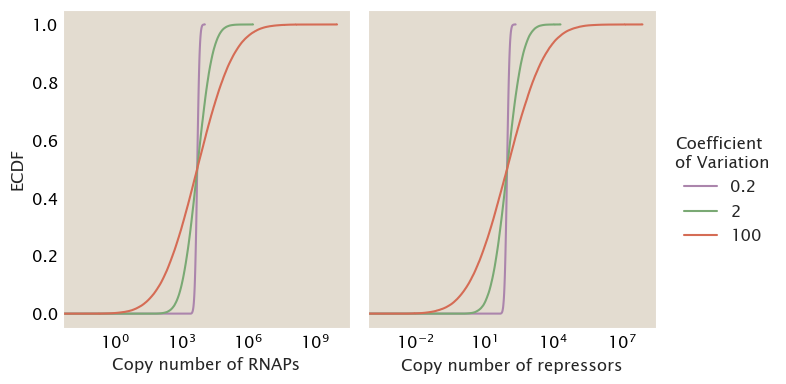

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax1, ax2 = axes
sns.ecdfplot(dist_p, ax=ax1, label='0.2', color='#AB85AC')
sns.ecdfplot(dist_p_high, ax=ax1, label='2', color='#7AA974')
sns.ecdfplot(dist_p_very_high, ax=ax1, label='100', color='#D56C55')
ax1.set_xlabel('Copy number of RNAPs')
ax1.set_ylabel('ECDF')
ax1.set_xscale('log')

sns.ecdfplot(dist_r, ax=ax2, label='0.2', color='#AB85AC')
sns.ecdfplot(dist_r_high, ax=ax2, label='2', color='#7AA974')
sns.ecdfplot(dist_r_very_high, ax=ax2, label='100', color='#D56C55')
ax2.set_xlabel('Copy number of repressors')
ax2.set_xscale('log')
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1.45, 0.65), frameon=False,
		   title='Coefficient\nof Variation')

ax1.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.savefig(out_fdir + 'cov.pdf')